**IMPORTS**

In [48]:
# OTHER #
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# SKLEARN #
from sklearn.linear_model import (
RidgeCV,
ElasticNetCV,
LassoCV
) 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    r2_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

**DATA PIPELINE CLASS**

In [49]:

data = pd.read_csv(r"..\data\student_portuguese_clean.csv")

#Pipeline class has methods that can prepare the data for further use

class Pipeline:
    
    def __init__(self, data, prediction_column):
        self.data = data
        self.prediction_column = prediction_column
    def getX(self):
        return self.data.drop(self.prediction_column, axis=1).to_numpy()
    def getData(self):
        return self.data
    def getY(self):
        return self.data[self.prediction_column].to_numpy()
    def getNumericalColumns(self):
        return self.data.select_dtypes(include=['float64', 'int64']).columns
    def getCorrelationMatrix(self):
        correlation_matrix = self.data[self.getNumericalColumns()].corr()
        
        plt.figure(figsize=(8, 8))
        sns.heatmap(correlation_matrix,
                    annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title('Correlation Matrix of Numerical Columns')
        plt.show()
    def getDummies(self):
        #Represent non-numerical features numerically
        numerical_columns = self.getNumericalColumns()
        non_numerical_columns = self.data.columns.difference(numerical_columns)
    
        return pd.get_dummies(self.data, columns=non_numerical_columns, drop_first=True)
    def getCorrelationList(self):
        return self.getDummies().corr()["final_grade"].sort_values(ascending=False)

**X AND Y**

In [50]:
pipeline = Pipeline(data.drop("student_id", axis=1), "final_grade")

dummies = pipeline.getDummies()

X = dummies.drop("final_grade", axis = 1).to_numpy()
y = dummies["final_grade"].to_numpy()

#Standardizing input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42, shuffle=True)

**REGRESSION**


            R2 Score
Lasso       0.935478
ElasticNet  0.926251
Ridge       0.910174


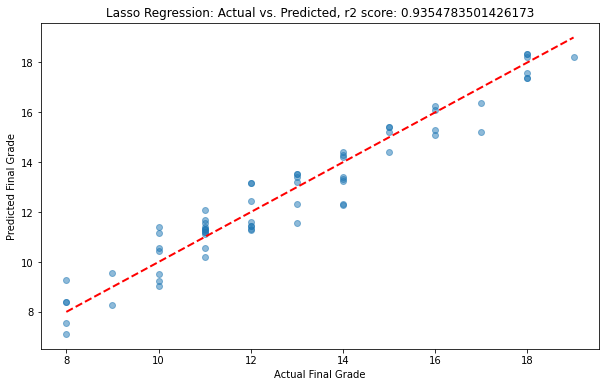

In [5]:

regression_models = {
    "Lasso" : LassoCV(cv=10).fit(X_train, y_train),
    "ElasticNet" : ElasticNetCV(cv=10).fit(X_train, y_train),
    "Ridge" : RidgeCV(cv=10).fit(X_train, y_train)
}


#A simple scatter plot of ytest and ypred, a good model should follow a diagonal line y=x
def makeScatter(ytest, ypred, r2score, modelname):
    plt.figure(figsize=(10, 6))
    plt.scatter(ytest, ypred, alpha=0.5)
    plt.plot([min(ytest), max(ytest)], [min(ytest), max(ytest)], '--', color='red', linewidth=2)  # Diagonal line
    plt.title(f'{modelname} Regression: Actual vs. Predicted, r2 score: {r2score}')
    plt.xlabel('Actual Final Grade')
    plt.ylabel('Predicted Final Grade')
    plt.show()


results = pd.DataFrame(columns=["R2 Score"], index=list(regression_models.keys()))
for modelname, model in regression_models.items():
    y_pred = model.predict(X_test)
    r2score = r2_score(y_test, y_pred)
    results.loc[modelname, :] = [r2score]
    

print(results)
# Convert the "R2 Score" column to numeric before using idxmax()
results["R2 Score"] = pd.to_numeric(results["R2 Score"])
best_model_name = results.idxmax()["R2 Score"]  # Get the model name with the highest R2 score
best_model = regression_models[best_model_name]  # Retrieve the best model from the dictionary
y_pred_best_model = best_model.predict(X_test)

makeScatter(y_test, y_pred_best_model, results.loc[best_model_name, "R2 Score"], best_model_name)

**BINARY CLASSIFICATION**


                           Test accuracy
DecisionTreeClassifier          0.923077
GradientBoostingClassifier      0.938462
KNeighborsClassifier            0.953846


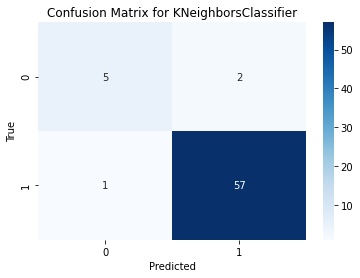

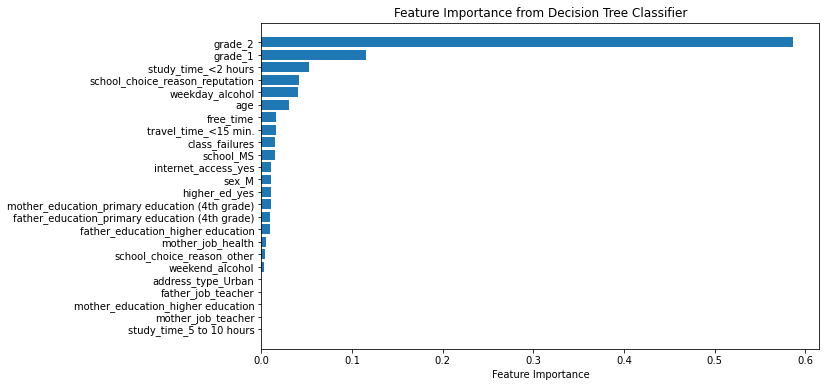

In [6]:
#Here the problem is reformulated to be solved like a binary classificaiton problem.
#Now we are not looking for a numerical prediction of the grade, rather a pass/fail prediction


#If correlation is less than abs(threshold) we discard the feature to reduce complexity/noise
threshold = 0.1

dummies_copy = dummies.copy()

for key, value in dummies_copy.corr()["final_grade"].iteritems():
  if abs(value) < threshold:
    dummies_copy.drop(columns= key, inplace=True)

#We transform y to a binary classification problem with a lambda function
#X greater than 10 means pass and less than is fail
X = dummies_copy.drop('final_grade',axis = 1)
y = dummies_copy['final_grade'].apply(lambda x: 'pass' if x >= 10 else 'fail')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)


classification_models = {
    "DecisionTreeClassifier" : DecisionTreeClassifier().fit(X_train, y_train),
    "GradientBoostingClassifier" : GradientBoostingClassifier().fit(X_train, y_train),
    "KNeighborsClassifier" : KNeighborsClassifier().fit(X_train, y_train)  
}

results = pd.DataFrame(columns=["Test accuracy"], index=list(classification_models.keys()))

for modelname, model in classification_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.loc[modelname, :] = [accuracy]

print(results)
# Convert the "Test accuracy" column to numeric before using idxmax()
results["Test accuracy"] = pd.to_numeric(results["Test accuracy"])
best_model_name = results.idxmax()["Test accuracy"]  # Get the model name with the highest accuracy
best_model = classification_models[best_model_name]  # Retrieve the best model from the dictionary

y_pred_best_model = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best_model)

# Plot confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


# Get feature importances
feature_importances = classification_models["DecisionTreeClassifier"].feature_importances_

# Match feature importances with feature names 
feature_importance_dict = dict(zip(X_train.columns, feature_importances))

# Sort feature importances in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

features, importances = zip(*sorted_feature_importances)

# Create a horizontal bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Decision Tree Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

**ANN**

In [55]:
# Data Preprocessing
pipeline = Pipeline(data.drop("student_id", axis=1), "final_grade")
dummies = pipeline.getDummies()

scaler = StandardScaler()

# Split the dataset
X = dummies.drop("final_grade", axis = 1).to_numpy()
y = dummies["final_grade"].to_numpy()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Neural Network Model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
before_tuning = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

Epoch 1/150
13/13 [==============================] - 2s 23ms/step - loss: 134.7421 - val_loss: 134.4849
Epoch 2/150
13/13 [==============================] - 0s 5ms/step - loss: 129.5974 - val_loss: 131.2155
Epoch 3/150
13/13 [==============================] - 0s 4ms/step - loss: 127.4653 - val_loss: 130.1648
Epoch 4/150
13/13 [==============================] - 0s 5ms/step - loss: 126.8388 - val_loss: 129.8291
Epoch 5/150
13/13 [==============================] - 0s 5ms/step - loss: 126.6339 - val_loss: 129.7022
Epoch 6/150
13/13 [==============================] - 0s 4ms/step - loss: 126.5491 - val_loss: 129.6437
Epoch 7/150
13/13 [==============================] - 0s 4ms/step - loss: 126.5095 - val_loss: 129.6098
Epoch 8/150
13/13 [==============================] - 0s 4ms/step - loss: 126.4860 - val_loss: 129.5880
Epoch 9/150
13/13 [==============================] - 0s 4ms/step - loss: 126.4701 - val_loss: 129.5730
Epoch 10/150
13/13 [==============================] - 0s 4ms/step - loss

In [13]:
#Improving the model by hypertuning the parameters 

scaler = StandardScaler()

# Split the dataset
X = dummies.drop("final_grade", axis=1).to_numpy()
y = dummies["final_grade"].to_numpy()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Neural Network Model
def create_model(activation='relu', neurons1=64, neurons2=32):
    model = Sequential()
    model.add(Dense(neurons1, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(neurons2, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define the parameter grid
param_grid = {
    'activation': ['relu', 'tanh', 'sigmoid'],
    'neurons1': [32, 64, 128],
    'neurons2': [16, 32, 64],
    'epochs': [100, 150, 200,],
    'batch_size': [16, 32, 64, 128]
}

# Create the KerasRegressor
keras_model = KerasRegressor(build_fn=create_model, verbose=0)

# Use GridSearchCV to find the best hyperparameters
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and corresponding negative MSE score
print("Best Parameters: ", grid_result.best_params_)
print("Best Negative MSE Score: ", grid_result.best_score_)

# Evaluate the model with the best parameters on the test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set: ", mse)

C:\Users\danie\AppData\Local\Temp\ipykernel_2972\4010560108.py:38: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasRegressor(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters:  {'activation': 'sigmoid', 'batch_size': 16, 'epochs': 100, 'neurons1': 128, 'neurons2': 64}
Best Negative MSE Score:  -2.1937454828160927
Mean Squared Error on Test Set:  2.06284497578946


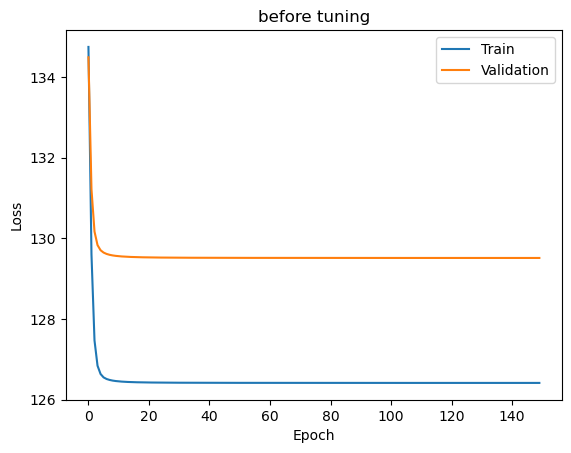

5/5 [==============================] - 0s 1ms/step
Mean Squared Error on Test Set:  138.6619662620069


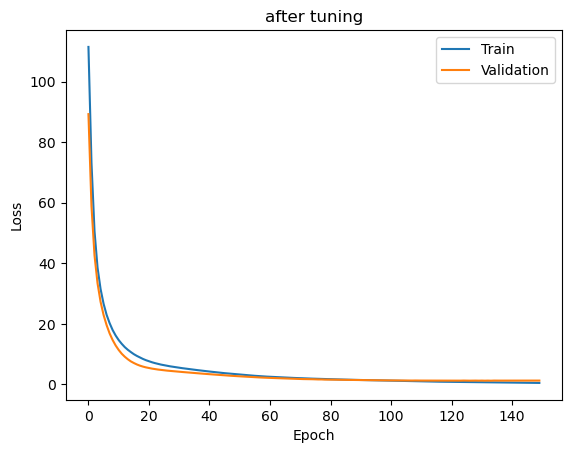

Mean Squared Error on Test Set:  2.2318901113056078


In [56]:
# Function to plot learning curves
def plot_learning_curves(history, title):
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#before_tuning = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)
plot_learning_curves(before_tuning, 'before tuning')
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set: ", mse)


after_tuning = best_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2)
plot_learning_curves(after_tuning, 'after tuning')
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set: ", mse)
print(best_model)

**SVM**

Best Hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Mean Absolute Error on Test Set: 0.75
0.8645852656212097


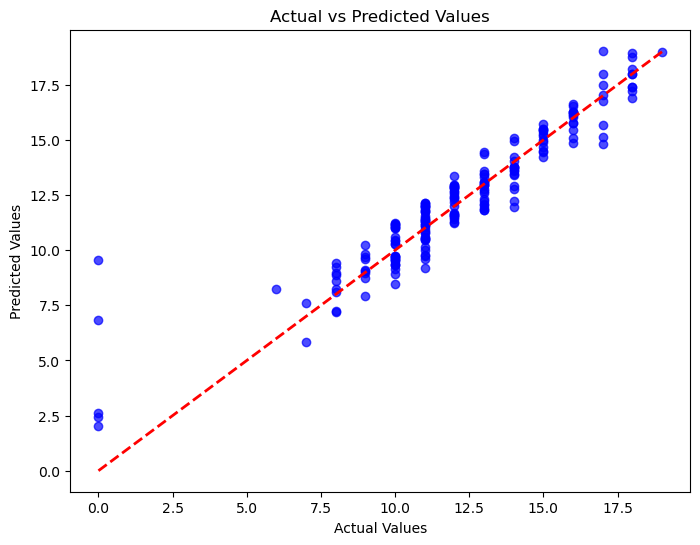

In [54]:
pipeline = Pipeline(data.drop("student_id", axis=1), "final_grade")

dummies = pipeline.getDummies()

X = dummies.drop("final_grade", axis = 1).to_numpy()
y = dummies["final_grade"].to_numpy()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the parameter grid to search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}

# Create an SVR regressor
svm_regressor = SVR()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svm_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test)

# Evaluate the performance using mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Set: {mae:.2f}")
r2 = r2_score(y_test, np.round(y_pred))
print(r2)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()